# Bias Check in IBM Quantum Backends: States with more Ket 1 Qubits
The following tests are conducted to check if there is any bias towards quantum states with more 1s. I will be validating this through running two Grover circuits for a vertex coloring instance. The first circuit will try to search for a solution state with more 0s. The second circuit, called inverted circuit, will look for a solution state with more 1s.

To have a controlled environment, the following conditions are applied:
- Both of the circuits are to be transpiled to the same qubit layout obtained from the transpilation of the first circuit.
- At least 2 different backends are tested. 
- The best and worst qubits are chosen on the backends and the experiments are on both layouts.
- Each experiment is run 10 times with 10,000 shots each, on the same qubits. 

### 1. Prepare the circuit and add the uniform state preparation operator. 

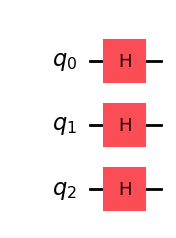

In [1]:
from qiskit import *

# Subcircuit for uniform state preparation operator
state_prep_oracle= QuantumCircuit(3,name="state_prep")

# Add a H gate on all qubits except the last one
# This will give the superposition of all the qubits except the last one
for qubit in range(3):
    state_prep_oracle.h(qubit)

# qc.decompose(gates_to_decompose="state_prep").draw('mpl')
state_prep_oracle.draw('mpl')

### 2. Manually creating the oracle circuit for evaluating the scaled down vertex coloring problem shown below

![Simple Vertex Coloring problem](images/vertex_coloring_instance.png)

#### Regular Grover Oracle

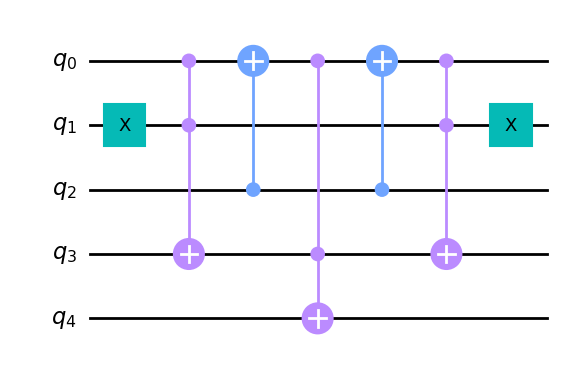

In [2]:
grover_oracle_reg = QuantumCircuit(5, name="grover_oracle_reg")
grover_oracle_reg.x(1)
grover_oracle_reg.ccx(0,1,3)
grover_oracle_reg.cx(2,0)
grover_oracle_reg.ccx(0,3,4)
grover_oracle_reg.cx(2,0)
grover_oracle_reg.ccx(0,1,3)
grover_oracle_reg.x(1)

grover_oracle_reg.draw('mpl',style='clifford')

#### Inverted Grover Oracle

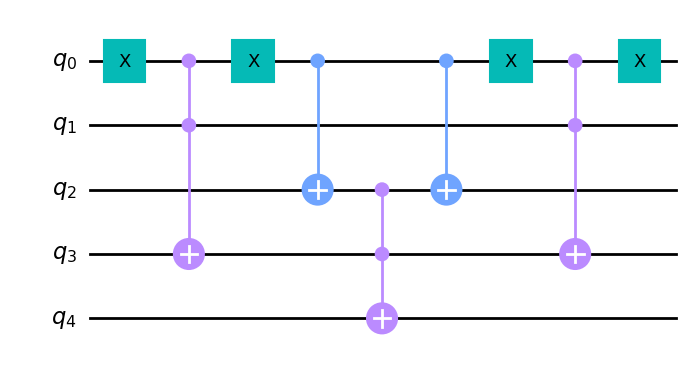

In [3]:

# Create a quantum subcircuit for grover oracle
grover_oracle_inverted = QuantumCircuit(5, name="grover_oracle_inverted")
grover_oracle_inverted.x(0)
grover_oracle_inverted.ccx(0,1,3)
grover_oracle_inverted.x(0)
grover_oracle_inverted.cx(0,2)
grover_oracle_inverted.ccx(2,3,4)
grover_oracle_inverted.cx(0,2)
grover_oracle_inverted.x(0)
grover_oracle_inverted.ccx(0,1,3)
grover_oracle_inverted.x(0)

grover_oracle_inverted.draw('mpl',style='clifford')


### 3. Defining the diffusion operator

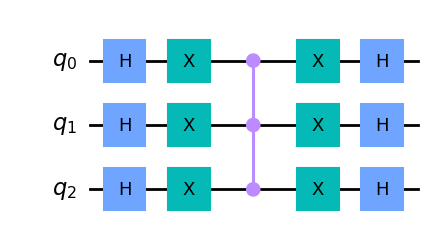

In [4]:
# Create a quantum subcircuit for grover diffusion operator
grover_diffusion = QuantumCircuit(3, name="grover_diffusion")
grover_diffusion.h([0,1,2])
grover_diffusion.x([0,1,2])
grover_diffusion.ccz(0,1,2)
grover_diffusion.x([0,1,2])
grover_diffusion.h([0,1,2])

grover_diffusion.draw('mpl',style='clifford')

### 4. Connect the whole circuit together

In [5]:
# Combining the subcircuits to form the complete Grover's algorithm
# Create a Quantum Circuit acting on a quantum register of 5 qubits

def prepare_circuit(qc: QuantumCircuit, state_prep: QuantumCircuit, grover_oracle: QuantumCircuit, grover_diff: QuantumCircuit):
    qc.barrier()
    qc.x(4)
    qc.h(4)
    # Apply the state preparation operator
    qc.append(state_prep, [0, 1, 2])
    qc.barrier()
    # Apply the Grover oracle
    qc.append(grover_oracle, [0, 1, 2, 3, 4])
    qc.barrier()
    # Apply the Grover diffusion operator
    qc.append(grover_diff, [0, 1, 2])
    qc.barrier()

qc_reg = QuantumCircuit(5, 5)
prepare_circuit(qc_reg, state_prep_oracle, grover_oracle_reg, grover_diffusion)
qc_inverted = QuantumCircuit(5, 5) 
prepare_circuit(qc_inverted, state_prep_oracle, grover_oracle_inverted, grover_diffusion)

#### Regular Circuit

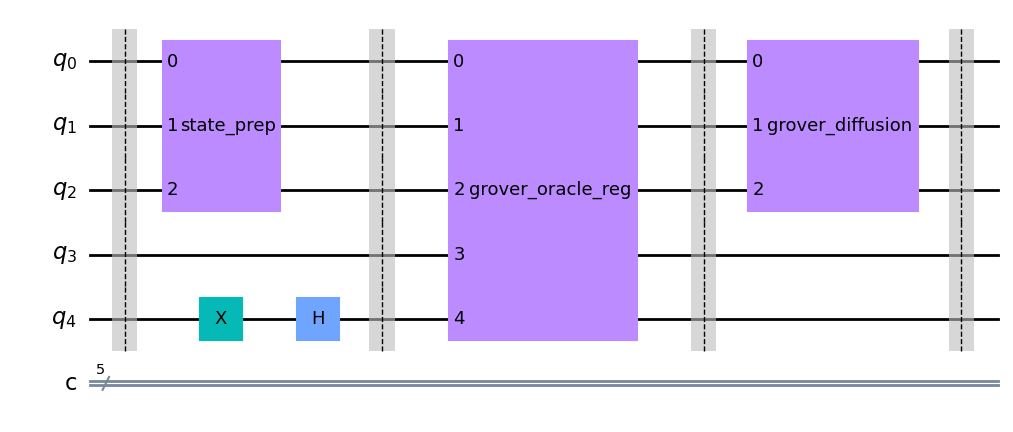

In [6]:

qc_reg.draw('mpl', style='clifford', filename='grover_circuit_reg.png')

#### Inverted Circuit

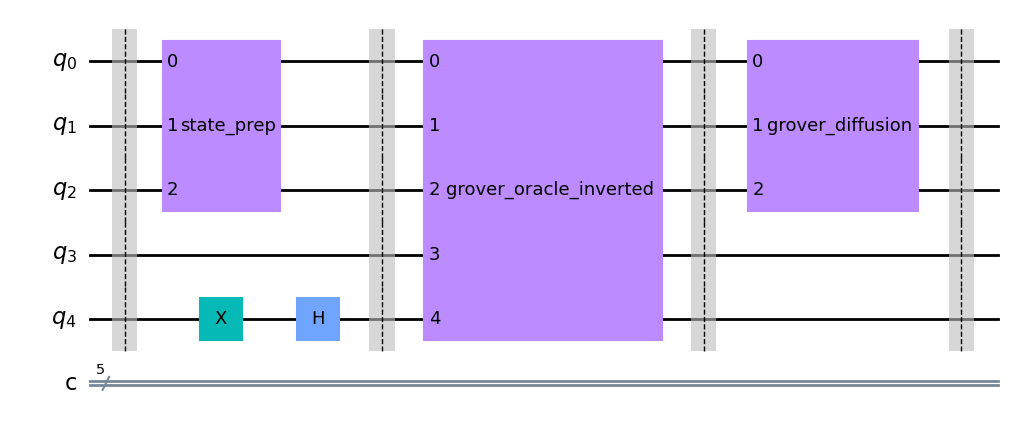

In [7]:
qc_inverted.draw('mpl', style='clifford', filename='grover_circuit_inverted.png')

### 5. Add measurements and decompose the circuits for the AER simulator

#### Regular circuit

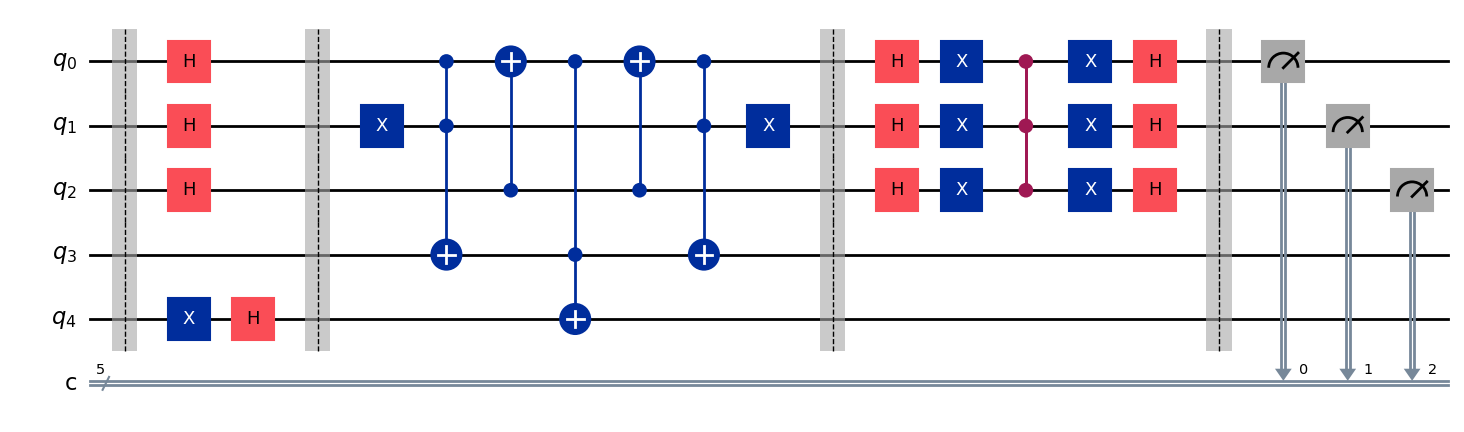

In [8]:
# qc.measure_all(add_bits=False)
qc_reg.measure([0, 1, 2], [0, 1, 2]) # Measure the first 3 qubits
qc_decomposed_reg : QuantumCircuit = qc_reg.decompose(gates_to_decompose=["state_prep", "grover_oracle_reg", "grover_diffusion"])
qc_decomposed_reg.draw('mpl')


#### Inverted Circuit

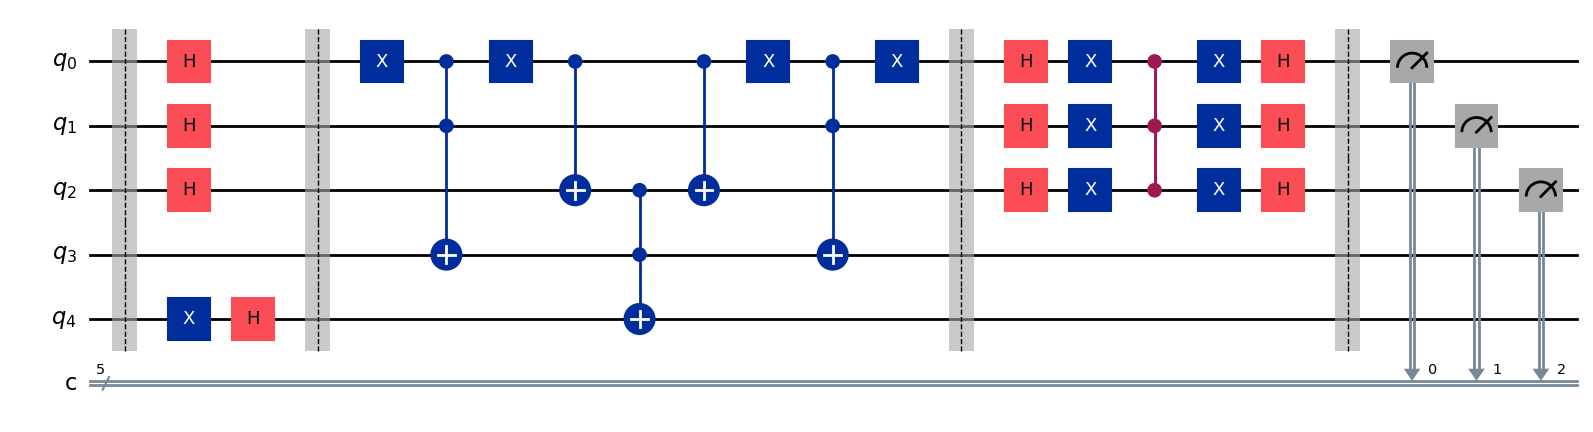

In [9]:
qc_inverted.measure([0, 1, 2], [0, 1, 2]) # Measure the first 3 qubits
qc_decomposed_inverted : QuantumCircuit = qc_inverted.decompose(gates_to_decompose=["state_prep", "grover_oracle_inverted", "grover_diffusion"])
qc_decomposed_inverted.draw('mpl')

### 6. Run the circuits in the AER Simulator

##### Prepare the AER Simulator

In [10]:
from qiskit_aer import Aer
# import basic plot tools
from qiskit.visualization import plot_histogram, plot_distribution

# Creating the backend
qasm_sim = Aer.get_backend('qasm_simulator')

# A function to extract the counts of the useful qubits
def process_counts(counts, num_qubits=3):
    # New dictionary to store our results in.
    new_counts = {f'{i:0{num_qubits}b}': 0 for i in range(2**num_qubits)}

    # Loop through the counts dictionary, adding the value to the 
    # respective key in new_counts based on what state the show_qubit is in
    for count in counts:
        count_idx = (len(count) - num_qubits)
        new_counts[count[count_idx:count_idx+num_qubits]] += counts[count]
    
    return new_counts

#### Regular Circuit

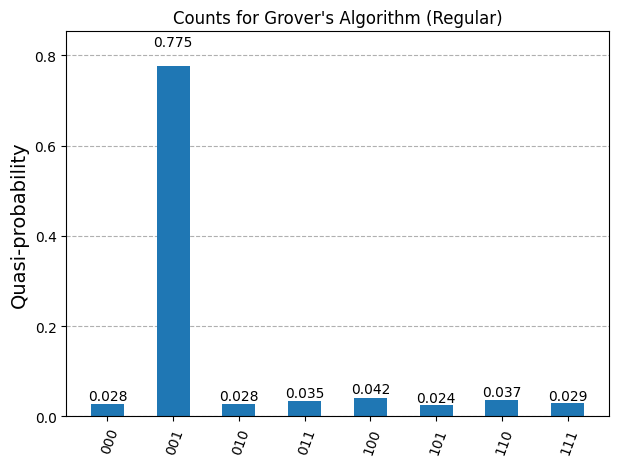

In [11]:
result_reg = qasm_sim.run(qc_decomposed_reg).result()
counts_reg = result_reg.get_counts()
counts_reg = process_counts(counts_reg, num_qubits=3)

plot_distribution(counts_reg, title="Counts for Grover's Algorithm (Regular)")

#### Inverted Circuit

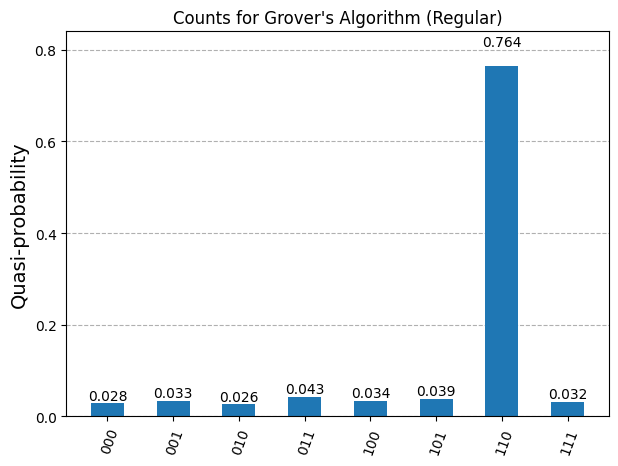

In [12]:
result_inverted = qasm_sim.run(qc_decomposed_inverted).result()
counts_inverted = result_inverted.get_counts()
counts_inverted = process_counts(counts_inverted, num_qubits=3)

plot_distribution(counts_inverted, title="Counts for Grover's Algorithm (Regular)")

### 7. Preparing Real IBM Quantum Device Backends

#### Getting a chosen backend and the least busy backend

In [ ]:
# Save account (Only once)

# token = " "
# from qiskit_ibm_runtime import QiskitRuntimeService
 
# QiskitRuntimeService.save_account(
#   token=token,
#   channel="ibm_quantum" # `channel` distinguishes between different account types
# )

In [15]:

# Run our circuit on the least busy backend. Transpiling before running.
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()

least_busy_backend = service.least_busy(simulator=False, operational=True)
pick_backend = service.backend("ibm_brisbane")

least_busy_target = least_busy_backend.target
pick_target = pick_backend.target
print(f"Least busy backend: {least_busy_backend.name}")
print(f"The other backend: {pick_backend.name}")



Least busy backend: ibm_sherbrooke
The other backend: ibm_brisbane


#### Dynamic Decoupling Circuit (JB's code)
This code snippet demonstrates the use of dynamic decoupling to mitigate decoherence in quantum circuits. The `PassManager` is configured with the `ALAPScheduleAnalysis` and `PadDynamicalDecoupling` passes to apply dynamic decoupling sequences to the circuit. The optimized circuits are then transpiled and their depths are printed.

In [16]:
from qiskit.transpiler import PassManager
from qiskit.circuit.library import XGate
from qiskit_ibm_runtime.transpiler.passes.scheduling import ALAPScheduleAnalysis, PadDynamicalDecoupling, DynamicCircuitInstructionDurations

durations = DynamicCircuitInstructionDurations.from_backend(backend=least_busy_backend)
 
optimized_pm = generate_preset_pass_manager(target=least_busy_target, optimization_level=3)
dd_rep = 8
dd_sequence = [XGate()] * dd_rep

optimized_pm.scheduling = PassManager([
    ALAPScheduleAnalysis(durations=durations),
    PadDynamicalDecoupling(
        durations=durations,
        dd_sequences=dd_sequence,
        pulse_alignment=16
    )
])

NUM_TRIAL = 10
reg_transpiled_circuits = []
inverted_transpiled_circuits = []
for i in range(NUM_TRIAL):
    reg_transpiled_circuits.append(optimized_pm.run(qc_reg))
    inverted_transpiled_circuits.append(optimized_pm.run(qc_inverted))


reg_depths = [circuit.depth() for circuit in reg_transpiled_circuits]
inverted_depths = [circuit.depth() for circuit in inverted_transpiled_circuits]
print("Regular Circuit Depths:")
print(reg_depths)
print("Inverted Circuit Depths:")
print(inverted_depths)

Regular Circuit Depths:
[254, 249, 285, 249, 294, 249, 249, 254, 254, 249]
Inverted Circuit Depths:
[268, 268, 270, 268, 271, 277, 270, 270, 268, 268]


In [17]:

print("Regular Circuits Qubits:")
for circuit in reg_transpiled_circuits:
    print(circuit.layout.final_index_layout())
print("Inverted Circuits Qubits:")
for circuit in inverted_transpiled_circuits:
    print(circuit.layout.final_index_layout())


Regular Circuits Qubits:
[55, 68, 69, 70, 67]
[68, 69, 55, 70, 67]
[67, 68, 55, 69, 70]
[68, 69, 55, 70, 67]
[68, 55, 67, 69, 70]
[68, 69, 55, 70, 67]
[68, 69, 55, 70, 67]
[55, 68, 69, 70, 67]
[55, 68, 69, 70, 67]
[68, 69, 55, 70, 67]
Inverted Circuits Qubits:
[70, 74, 69, 89, 68]
[70, 74, 69, 89, 68]
[69, 70, 74, 89, 68]
[70, 74, 69, 89, 68]
[69, 70, 74, 89, 68]
[68, 69, 55, 70, 67]
[69, 70, 74, 89, 68]
[69, 70, 74, 89, 68]
[70, 74, 69, 89, 68]
[70, 74, 69, 89, 68]


In [18]:
reg_transpiled_circuit = reg_transpiled_circuits[0]
inverted_transpiled_circuit = inverted_transpiled_circuits[0]
used_qubits = list(set(reg_transpiled_circuit.layout.final_index_layout()).union(set(inverted_transpiled_circuit.layout.final_index_layout())))

print("Used Qubit for the Regular Circuit:")
print(reg_transpiled_circuit.layout.final_index_layout())
print("Used Qubit for the Inverted Circuit:")
print(inverted_transpiled_circuit.layout.final_index_layout())

Used Qubit for the Regular Circuit:
[55, 68, 69, 70, 67]
Used Qubit for the Inverted Circuit:
[70, 74, 69, 89, 68]


### 8. Run the circuits in the picked backend

In [98]:
import mthree
mit = mthree.M3Mitigation(pick_backend)
mit.cals_from_system(reg_transpiled_circuit.layout.final_index_layout())
# Running the transpiled circuits using the sampler
from qiskit_ibm_runtime import Sampler
sampler = Sampler(mode=pick_backend)
sampler.options.default_shots = 10_000
job = sampler.run([reg_transpiled_circuit, inverted_transpiled_circuit])

### $\color{yellow}{\text{9. Plot the results }}$

#### Regular Circuit

In [105]:
from qiskit.visualization import plot_distribution
result = job.result()
reg_raw_counts = result[0].data.c.get_counts()
counts = process_counts(reg_raw_counts)
plot_histogram(counts)

KeyboardInterrupt: 

#### Inverted Circuit

In [ ]:
inverted_raw_counts = result[1].data.c.get_counts()
counts = process_counts(inverted_raw_counts)
plot_histogram(counts)

### $\color{orange}{\text{10. M3 Mitigation Correction}}$

#### Regular Circuit

In [106]:
reg_quasi = mit.apply_correction(reg_raw_counts, used_qubits)

mitigated_counts = {k: int(v*10_000) for k, v in reg_quasi.items()}

plot_distribution(process_counts(mitigated_counts))

NameError: name 'reg_raw_counts' is not defined

#### Inverted Circuit

In [107]:
inverted_quasi = mit.apply_correction(inverted_raw_counts, used_qubits)

mitigated_counts = {k: int(v*10_000) for k, v in inverted_quasi.items()}

plot_distribution(process_counts(mitigated_counts))

NameError: name 'inverted_raw_counts' is not defined

# SHERBROOKE

In [152]:
from qiskit.transpiler import PassManager
from qiskit.circuit.library import XGate
from qiskit_ibm_runtime.transpiler.passes.scheduling import ALAPScheduleAnalysis, PadDynamicalDecoupling, DynamicCircuitInstructionDurations
durations = DynamicCircuitInstructionDurations.from_backend(backend=least_busy_backend)
 
# Define physical qubit mapping: {virtual_qubit: physical_qubit}
from qiskit.circuit import Qubit
from qiskit import QuantumRegister

qr = QuantumRegister(5, 'q')
initial_layout = {
    Qubit(qr, 0): 103,
    Qubit(qr, 1): 104,
    Qubit(qr, 2): 105,
    Qubit(qr, 3): 111,
    Qubit(qr, 4): 122
}

optimized_pm = generate_preset_pass_manager(target=least_busy_target, optimization_level=3, initial_layout=initial_layout)
dd_rep = 16
dd_sequence = [XGate()] * dd_rep

optimized_pm.scheduling = PassManager([
    ALAPScheduleAnalysis(durations=durations),
    PadDynamicalDecoupling(
        durations=durations,
        dd_sequences=dd_sequence,
        pulse_alignment=16
    )
])

NUM_TRIAL = 10
reg_transpiled_circuits = []
inverted_transpiled_circuits = []
for i in range(NUM_TRIAL):
    reg_transpiled_circuits.append(optimized_pm.run(qc_reg))
    inverted_transpiled_circuits.append(optimized_pm.run(qc_inverted))


reg_depths = [circuit.depth() for circuit in reg_transpiled_circuits]
inverted_depths = [circuit.depth() for circuit in inverted_transpiled_circuits]
print("Regular Circuit Depths:")
print(reg_depths)
print("Inverted Circuit Depths:")
print(inverted_depths)

Regular Circuit Depths:
[242, 240, 269, 242, 240, 267, 269, 242, 242, 267]
Inverted Circuit Depths:
[293, 293, 293, 266, 266, 266, 293, 266, 266, 293]


In [154]:
print("Regular Circuits Qubits:")
for circuit in reg_transpiled_circuits:
    print(circuit.layout.final_index_layout())
print("Inverted Circuits Qubits:")
for circuit in inverted_transpiled_circuits:
    print(circuit.layout.final_index_layout())

Regular Circuits Qubits:
[104, 103, 105, 111, 122]
[104, 103, 105, 111, 122]
[105, 104, 103, 111, 122]
[104, 103, 105, 111, 122]
[104, 103, 105, 111, 122]
[105, 104, 103, 111, 122]
[105, 104, 103, 111, 122]
[104, 103, 105, 111, 122]
[104, 103, 105, 111, 122]
[105, 104, 103, 111, 122]
Inverted Circuits Qubits:
[111, 104, 103, 105, 122]
[111, 104, 103, 105, 122]
[111, 104, 103, 105, 122]
[104, 103, 111, 105, 122]
[104, 103, 111, 105, 122]
[104, 103, 111, 105, 122]
[111, 104, 103, 105, 122]
[104, 103, 111, 105, 122]
[104, 103, 111, 105, 122]
[111, 104, 103, 105, 122]


In [164]:
reg_transpiled_circuit = reg_transpiled_circuits[1]
inverted_transpiled_circuit = inverted_transpiled_circuits[0]
used_qubits = list(set(reg_transpiled_circuit.layout.final_index_layout()).union(set(inverted_transpiled_circuit.layout.final_index_layout())))

print("Used Qubit for the Regular Circuit:")
print(reg_transpiled_circuit.layout.final_index_layout())
print("Used Qubit for the Inverted Circuit:")
print(inverted_transpiled_circuit.layout.final_index_layout())

Used Qubit for the Regular Circuit:
[104, 103, 105, 111, 122]
Used Qubit for the Inverted Circuit:
[111, 104, 103, 105, 122]


In [19]:
import mthree
from qiskit_ibm_runtime import Sampler
mit = mthree.M3Mitigation(least_busy_backend)
mit.cals_from_system(inverted_transpiled_circuit.layout.final_index_layout())
# Running the transpiled circuits using the sampler

sampler = Sampler(mode=least_busy_backend)
sampler.options.default_shots = 10_000
job = sampler.run([reg_transpiled_circuit, inverted_transpiled_circuit])

### $\color{yellow}{\text{9.2. Plot the results }}$

#### Regular Circuit

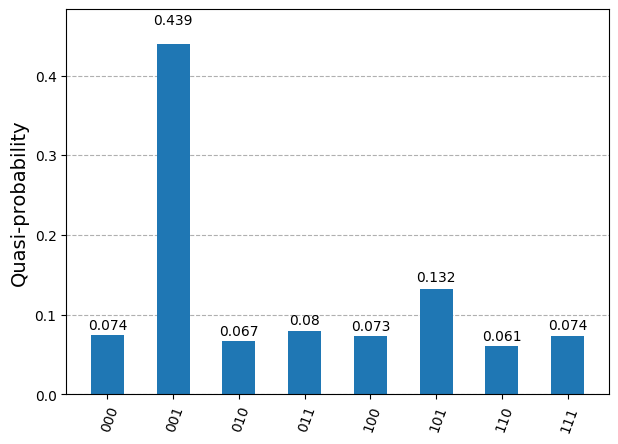

In [20]:
from qiskit.visualization import plot_distribution
result = job.result()
reg_raw_counts = result[0].data.c.get_counts()
counts = process_counts(reg_raw_counts)
plot_distribution(counts)

#### Inverted Circuit

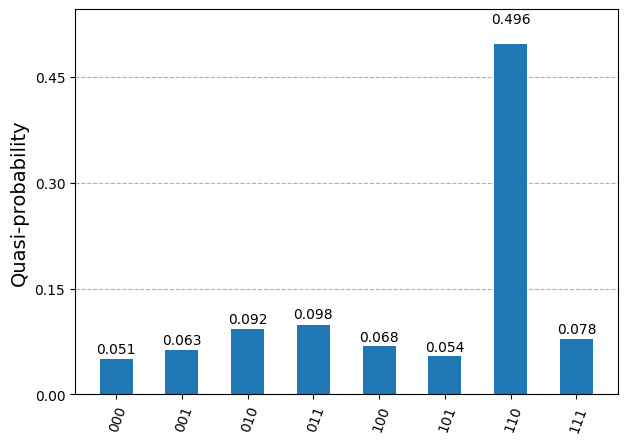

In [21]:
inverted_raw_counts = result[1].data.c.get_counts()
counts = process_counts(inverted_raw_counts)
plot_distribution(counts)